## Stage 1: Install dependencies and setting up GPU environment

In [0]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2343  100  2343    0     0   127k      0 --:--:-- --:--:-- --:--:--  127k
OK


In [0]:
!apt-get update & apt-get install tensorflow-model-server

Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Reading package lists... Done
Hit:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Building dependency tree       
Reading state information... Done
0% [8 I

In [0]:
!pip install tensorflow-gpu==1.13.1

In [0]:
!pip install requests

## Stage 2: Import project dependencies

In [0]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'1.13.1'

## Stage 3: Dataset preprocessing

### Loading the dataset

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Image normalization

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [0]:
X_train.shape

(50000, 32, 32, 3)

## Stage 4: Defining the model

NOTE: We are using the model from the Section for Convolutional neural networks

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


### Compiling the model

In [0]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

### Training the model

In [0]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
50000/50000 [==============================] - 7s 141us/sample - loss: 1.4657 - sparse_categorical_accuracy: 0.4686
Epoch 2/10
50000/50000 [==============================] - 5s 96us/sample - loss: 1.0144 - sparse_categorical_accuracy: 0.6450
Epoch 3/10
50000/50000 [==============================] - 5s 96us/sample - loss: 0.8384 - sparse_categorical_accuracy: 0.7076
Epoch 4/10
50000/50000 [==============================] - 5s 95us/sample - loss: 0.7225 - sparse_categorical_accuracy: 0.7475
Epoch 5/10
50000/50000 [==============================] - 5s 96us/sample - loss: 0.6239 - sparse_categorical_accuracy: 0.7837
Epoch 6/10
50000/50000 [==============================] - 5s 96us/sample - loss: 0.5285 - sparse_categorical_accuracy: 0.8161
Epoch 7/10
50000/50000 [==============================] - 5s 96us/sample - loss: 0.4438 - sparse_categorical_accuracy: 0.8440
Epoch 8/10
50000/50000 [==============================] - 5s 96us/sample - loss: 0.3632 - sparse_categorical_accuracy

### Model evaluation

In [0]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 98us/sample - loss: 0.9765 - sparse_categorical_accuracy: 0.7377


In [0]:
print("Test accuracy is {}".format(test_accuracy))

Test accuracy is 0.7376999855041504


## Stage 5: Saving the model for production

### Creating the directory for the model

In [0]:
MODEL_DIR = "model/"
version = 1

In [0]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [0]:
if os.path.isdir(export_path):
    !rm -r {export_path}

### Saving the model for the TensorFlow Serving

In [0]:
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


## Stage 6: Setting up the production environment

### Exporting the MODEL_DIR to environment variables

In [0]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Running the TensorFlow Serving REST API

In [0]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [0]:
!tail server.log

2019-05-18 20:29:27.796175: E tensorflow_serving/sources/storage_path/file_system_storage_path_source.cc:369] FileSystemStoragePathSource encountered a file-system access error: Could not find base path /content//content/model for servable cifar10
2019-05-18 20:29:28.796442: E tensorflow_serving/sources/storage_path/file_system_storage_path_source.cc:369] FileSystemStoragePathSource encountered a file-system access error: Could not find base path /content//content/model for servable cifar10
2019-05-18 20:29:29.796596: E tensorflow_serving/sources/storage_path/file_system_storage_path_source.cc:369] FileSystemStoragePathSource encountered a file-system access error: Could not find base path /content//content/model for servable cifar10
2019-05-18 20:29:30.796709: E tensorflow_serving/sources/storage_path/file_system_storage_path_source.cc:369] FileSystemStoragePathSource encountered a file-system access error: Could not find base path /content//content/model for servable cifar10
2019-05-

## Stage 7: Creating the first POST request

In [0]:
random_image = np.random.randint(0, len(X_test))
random_image

620

### Creating the JSON data object

In [0]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [0]:
data

'{"signature_name": "serving_default", "instances": [[[[0.4823529411764706, 0.47058823529411764, 0.5019607843137255], [0.5019607843137255, 0.48627450980392156, 0.5215686274509804], [0.4588235294117647, 0.44313725490196076, 0.47843137254901963], [0.44313725490196076, 0.42745098039215684, 0.4627450980392157], [0.47843137254901963, 0.4666666666666667, 0.5058823529411764], [0.5098039215686274, 0.4980392156862745, 0.5450980392156862], [0.5333333333333333, 0.5176470588235295, 0.5647058823529412], [0.5450980392156862, 0.5215686274509804, 0.5568627450980392], [0.5529411764705883, 0.5176470588235295, 0.5490196078431373], [0.5411764705882353, 0.5019607843137255, 0.5372549019607843], [0.5254901960784314, 0.5019607843137255, 0.5372549019607843], [0.49411764705882355, 0.48627450980392156, 0.5254901960784314], [0.49019607843137253, 0.4823529411764706, 0.5215686274509804], [0.49411764705882355, 0.48627450980392156, 0.5254901960784314], [0.47058823529411764, 0.4627450980392157, 0.5019607843137255], [0

### Sending the first POST request to the model

In [0]:
headers = {"content-type":"application/json"}

In [0]:
json_response = requests.post(url="http://localhost:8501/v1/models/cifar10:predict", data=data, headers=headers)

In [0]:
json_response

<Response [200]>

In [0]:
predictions = json.loads(json_response.text)['predictions']

In [0]:
predictions

[[1.43151e-05,
  8.25434e-09,
  0.00420625,
  0.0147217,
  0.0125217,
  0.00353992,
  0.000103995,
  0.964891,
  1.08745e-06,
  5.2131e-09]]

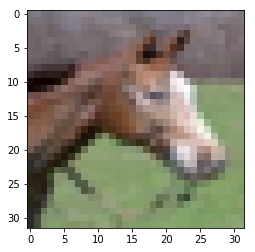

In [0]:
plt.imshow(X_test[random_image])

In [0]:
class_names[np.argmax(predictions[0])]

'horse'

## Stage 8: Sending the POST request to a specific model

In [0]:
specific_json_response = requests.post(url="http://localhost:8501/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [0]:
specific_json_response

<Response [200]>